# Introduction & Import Necessary Setup
In this labsheet, we'll delve into the fascinating world of autoencoders (AEs), a type of neural network renowned for its ability to compress and reconstruct data. Autoencoders work by first encoding input data, such as images, into a compact feature vector through an encoder network. This process effectively distills the essence of the data into a smaller, more manageable form. The feature vector, often referred to as the "bottleneck," plays a crucial role in this compression process, allowing us to represent the input data with fewer features.

Following compression, a second neural network, known as the decoder, takes over to reconstruct the original data from the compressed feature vector. This remarkable ability to compress and then reconstruct data makes autoencoders extremely valuable in various applications, including data compression and image comparison at a more meaningful level than mere pixel-by-pixel analysis.

Moreover, our exploration will not stop at the autoencoder framework itself. We will also introduce the concept of "deconvolution" (also known as transposed convolution), a powerful operator used to enlarge feature maps in both height and width dimensions. Deconvolution networks are indispensable in scenarios where we begin with a compact feature vector and aim to generate a full-sized image. This technique is pivotal in various advanced neural network applications, such as Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs), and super-resolution.

To kick things off, we'll start by importing our standard libraries, setting the stage for our deep dive into the inner workings and applications of autoencoders.

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

DATASET_PATH = "dataset"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_136250/3144314458.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cpu


# Download and setup the dataset
In this labsheet, our focus shifts to the CIFAR10 dataset, a collection known for its rich, colored images. Each image within CIFAR10 is equipped with 3 color channels and boasts a resolution of 32x32 pixels. This characteristic is particularly advantageous when working with autoencoders, as they are not bound by the constraints of probabilistic image modeling.

Should you already have the CIFAR10 dataset downloaded in a different directory, it's important to adjust the DATASET_PATH variable accordingly. This step ensures you avoid unnecessary additional downloads, streamlining your workflow and allowing you to dive into the practical exercises more swiftly.

In [2]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

 12%|█▏        | 20873216/170498071 [01:17<09:17, 268405.32it/s]


KeyboardInterrupt: 

# Building the autoencoder

In general, an autoencoder consists of an **encoder** that maps the input $x$ to a lower-dimensional feature vector $z$, and a **decoder** that reconstructs the input $\hat{x}$ from $z$. We train the model by comparing $x$ to $\hat{x}$ and optimizing the parameters to increase the similarity between $x$ and $\hat{x}$. See below for a small illustration of the autoencoder framework.


![img](https://raw.githubusercontent.com/hqsiswiliam/COM3025_Torch/main/autoencoder.png)


For an educational purpose revision in markdown format, the text could be enhanced as follows:

To kick off our exploration, we initiate with the construction of the encoder. This component is fundamentally a deep convolutional network tailored for progressively diminishing the image's dimensions. This diminution is achieved through the use of strided convolutions, which methodically reduce the image's size layer by layer. Following the thrice-executed downscaling process, we transition the architecture from convolutional layers to a flattened feature representation. This is achieved by flattening the spatial features into a single vector, which is then processed through several linear layers. As a result, we obtain the latent representation, denoted as
$z$, encapsulating the compressed essence of the input image. The size of this latent vector, $d$, is adjustable, providing flexibility in the encoding capacity of our network.

In [3]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x

# Task1
Now Complete the decoder implementation

In [4]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),  # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
        # You code goes here.
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2*16*c_hid),
            act_fn(),
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

# Combining Encoder and Decoder
## Loss Function: Mean Squared Error (MSE)

For our loss function, we opt for the Mean Squared Error (MSE). MSE is particularly effective in emphasizing the significance of accurately predicting pixel values that are substantially misestimated by the network. For instance, a minor deviation, such as predicting 127 instead of 128, is deemed less critical. However, larger discrepancies, like confusing a pixel value of 0 with 128, are considered more severe and detrimental to the reconstruction quality.

Unlike Variational Autoencoders (VAEs) that predict the probability for each pixel value, we employ MSE as a straightforward distance measure. This approach significantly reduces the number of parameters, streamlining the training process. To enhance our understanding of the per-pixel performance, we calculate the summed squared error, averaged across the batch dimension. It's important to note that alternative aggregations (mean or sum) yield equivalent outcomes in terms of resulting parameters.

### Limitations of MSE

Despite its advantages, MSE is not without drawbacks. Primarily, it tends to produce blurrier images, as it inherently removes small noise and high-frequency patterns, which contribute minimally to the overall error. To mitigate this and achieve more realistic reconstructions, integrating Generative Adversarial Networks (GANs) with autoencoders has proven effective. This hybrid approach is explored in various studies ([example 1](https://arxiv.org/abs/1704.02304), [example 2](https://arxiv.org/abs/1511.05644), and [slides](http://elarosca.net/slides/iccv_autoencoder_gans.pdf)).

Furthermore, MSE may not always accurately reflect visual similarity between images. A case in point is when an autoencoder produces an image that is slightly shifted—despite the near-identical appearance, the MSE can significantly increase, showcasing a limitation in capturing true visual fidelity. A potential solution involves leveraging a pre-trained CNN to measure distance based on visual features extracted from lower layers, offering a more nuanced comparison than pixel-level MSE.


In [5]:
class Autoencoder(nn.Module):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

# Utility code for comparing Images

In [8]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

NameError: name 'train_dataset' is not defined

# Task2
Add training code to train the AutoEncoder

In [11]:
# train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
# test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)


# for batch in tqdm(train_loader, total=len(train_loader)):

def train_one_epoch():
    running_loss = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        loss = model._get_reconstruction_loss(inputs)        
        loss.backward()
        running_loss += loss
        optimizer.step()
    return running_loss/len(train_loader)

import torch.optim as optim
epoch_number = 0
model = Autoencoder(base_channel_size=32, latent_dim=64)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # your code here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs') 
# your code here, can use ReduceLROnPlateau

latest_dim = [64, 128, 256, 512, 1024]

for dim in latest_dim:
    model = Autoencoder(base_channel_size=256, latent_dim=4096)
    model.train()

    EPOCHS = 20
    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} ")
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch()
        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        print(f"{avg_loss}")
        epoch_number += 1


Epoch 1/20 


841.76904296875
Epoch 2/20 
841.867919921875
Epoch 3/20 
842.1146240234375
Epoch 4/20 
841.83251953125
Epoch 5/20 
842.1197509765625
Epoch 6/20 
841.9930419921875
Epoch 7/20 
842.0438232421875
Epoch 8/20 
842.1286010742188
Epoch 9/20 
841.8350830078125
Epoch 10/20 
842.1332397460938
Epoch 11/20 
841.8993530273438
Epoch 12/20 
842.2437744140625
Epoch 13/20 
842.0397338867188
Epoch 14/20 
841.834716796875
Epoch 15/20 
842.0565185546875
Epoch 16/20 
842.0715942382812
Epoch 17/20 
841.86328125
Epoch 18/20 
842.0873413085938
Epoch 19/20 
842.1405639648438
Epoch 20/20 
841.9917602539062
Epoch 1/20 
845.9091186523438
Epoch 2/20 
845.7990112304688
Epoch 3/20 
845.8921508789062
Epoch 4/20 
845.652587890625
Epoch 5/20 
845.8869018554688
Epoch 6/20 
845.5588989257812
Epoch 7/20 
845.61279296875
Epoch 8/20 
845.970703125
Epoch 9/20 
845.9404296875
Epoch 10/20 
845.8103637695312
Epoch 11/20 
845.8341064453125
Epoch 12/20 
845.6771240234375
Epoch 13/20 
845.6812744140625
Epoch 14/20 
845.74975585937

KeyboardInterrupt: 

In [9]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from model")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)

NameError: name 'get_train_images' is not defined

# Masked AutoEncoder
The follow code are the demonstration of Masked Autoencoder implementation and visualization

# Import Necessary Libraries

In [12]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
from Lab3.mae import models_mae

ModuleNotFoundError: No module named 'util'

# Build up necessary utillities

In [13]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# Load one image

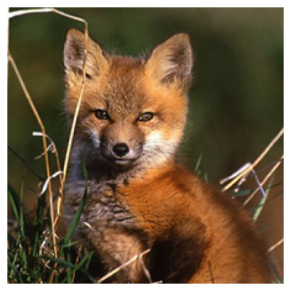

In [14]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [11]:
# Patch for numpy error
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.



NameError: name 'models_mae' is not defined

In [15]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

MAE with pixel reconstruction:


NameError: name 'model_mae' is not defined